<a href="https://colab.research.google.com/github/niyamaryam/Image-classification-using-CNN-model/blob/main/ImageClassification_cats_vs_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup Google Colab Environment

1. Make sure the runtime is set to GPU:
*   Go to Runtime → Change Runtime Type → Select GPU.

Install Dependencies

In [1]:
!pip install tensorflow opencv-python matplotlib

Download and Unzip Dataset

In [2]:
#install kaggle
!pip install -q kaggle

In [3]:
from  google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"niyamaryam","key":"cad1e556ada7d2c3000afdb9b78730bc"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
 98% 1.05G/1.06G [00:09<00:00, 166MB/s]
100% 1.06G/1.06G [00:09<00:00, 126MB/s]


In [7]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

Organize Data into Classes

In [8]:
import os
import shutil
from pathlib import Path

# Define paths for train and test directories
train_path = Path("/content/data/train")
test_path = Path("/content/data/test")

# Define output directories for sorted data
sorted_train_path = Path("/content/data/sorted_data/train")
sorted_test_path = Path("/content/data/sorted_data/test")

# Create class directories for train and test sets
for split in ['train', 'test']:
    for category in ['cats', 'dogs']:
        os.makedirs(f"/content/data/sorted_data/{split}/{category}", exist_ok=True)

# Function to sort images into respective folders
def sort_images(data_path, output_path):
    for img_file in data_path.glob("*.jpg"):
        if "cat" in img_file.name:
            shutil.move(str(img_file), output_path / "cats" / img_file.name)
        else:
            shutil.move(str(img_file), output_path / "dogs" / img_file.name)

# Sort train and test images
sort_images(train_path, sorted_train_path)
sort_images(test_path, sorted_test_path)

print("Images sorted successfully!")


Images sorted successfully!


 Remove Corrupt or Dodgy Images

In [9]:
import os
import cv2
import imghdr
from pathlib import Path

# Define the output path
output_path = Path("/content/data/sorted_data/")

# Define valid image extensions
valid_extensions = ['jpeg', 'jpg', 'png']

# Check and remove invalid images from train and test datasets
for split in ['train', 'test']:
    for category in ['cats', 'dogs']:
        folder_path = output_path / split / category
        if not folder_path.exists():
            print(f"Folder not found: {folder_path}")
            continue
        for img_file in folder_path.iterdir():
            try:
                img = cv2.imread(str(img_file))
                if imghdr.what(img_file) not in valid_extensions:
                    os.remove(img_file)  # Remove invalid image
            except Exception as e:
                os.remove(img_file)  # Remove problematic file



In [10]:
import os

# Check if train and validation directories have images
print("Train directory:", os.listdir('/content/data/sorted_data/train'))
print("Test directory:", os.listdir('/content/data/sorted_data/test'))


Train directory: ['cats', 'dogs']
Test directory: ['cats', 'dogs']


Load and Preprocess Data

In [11]:
import tensorflow as tf

# Define parameters
img_size = (256, 256)       # Resize all images to 256x256
batch_size = 32             # Batch size for training and validation

# Create training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/dogs_vs_cats/train',         # Path to training images
    validation_split=0.2,                  # Split 20% for validation
    subset="training",                     # Subset as training data
    seed=123,                              # Seed for reproducibility
    image_size=img_size,                   # Resize images to 256x256
    batch_size=batch_size                  # Batch size for training
)

# Create validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/dogs_vs_cats/train',         # Path to training images
    validation_split=0.2,                  # Split 20% for validation
    subset="validation",                   # Subset as validation data
    seed=123,                              # Seed for reproducibility
    image_size=img_size,                   # Resize images to 256x256
    batch_size=batch_size                  # Batch size for validation
)



Found 20000 files belonging to 2 classes.
Using 16000 files for training.
Found 20000 files belonging to 2 classes.
Using 4000 files for validation.


In [12]:
from tensorflow.keras.layers import RandomFlip, RandomRotation

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x) / 255.0, y))
val_ds = val_ds.map(lambda x, y: (x / 255.0, y))


Build the CNN Model

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),   # First convolutional layer with 32 filters
    MaxPooling2D(),                                                     # MaxPooling layer to reduce dimensions
    Conv2D(64, (3, 3), activation='relu'),                              # Second convolutional layer with 64 filters
    MaxPooling2D(),                                                     # MaxPooling layer
    Conv2D(128, (3, 3), activation='relu'),                             # Third convolutional layer with 128 filters
    MaxPooling2D(),                                                     # MaxPooling layer
    Flatten(),                                                          # Flatten the 2D feature map to a 1D vector
    Dense(256, activation='relu'),                                      # Dense layer with 256 neurons
    Dropout(0.5),                                                       # Dropout to prevent overfitting
    Dense(1, activation='sigmoid')                                      # Output layer with sigmoid activation (binary classification)
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()                                                         # Purpose: Provides a detailed overview of the model's architecture. Layer Details: Lists each layer, its type, and output shape (e.g., convolutional layers, pooling layers, etc.). Number of Parameters: Shows how many learnable parameters each layer has. This helps understand the model's complexity.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      29,491,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,584,961 (112.86 MB)

 Trainable params: 29,584,961 (112.86 MB)

 Non-trainable params: 0 (0.00 B)

Train the Model

In [14]:
# Define the log directory for TensorBoard
log_dir = "logs"

# Set up TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

# Train the CNN model
history = model.fit(
    train_ds,                  # Training dataset
    validation_data=val_ds,    # Validation dataset
    epochs=10,                 # Number of training cycles
    callbacks=[tensorboard_callback]  # TensorBoard to monitor performance
)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 184s 350ms/step - accuracy: 0.5508 - loss: 0.8908 - val_accuracy: 0.5965 - val_loss: 0.6711
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 174s 348ms/step - accuracy: 0.6099 - loss: 0.6596 - val_accuracy: 0.6672 - val_loss: 0.6210
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 171s 341ms/step - accuracy: 0.6574 - loss: 0.6259 - val_accuracy: 0.7143 - val_loss: 0.5838
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 169s 337ms/step - accuracy: 0.6923 - loss: 0.5945 - val_accuracy: 0.7253 - val_loss: 0.5453
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 202s 338ms/step - accuracy: 0.7125 - loss: 0.5614 - val_accuracy: 0.7558 - val_loss: 0.5182
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 170s 340ms/step - accuracy: 0.7278 - loss: 0.5464 - val_accuracy: 0.7398 - val_loss: 0.5230
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 205s 347ms/step - accuracy: 0.7411 - loss: 0.5228 - val_accuracy: 0.7785 - val_loss: 0.4675
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 169s 337ms/step - accuracy: 0.7538 -

Plot Performance

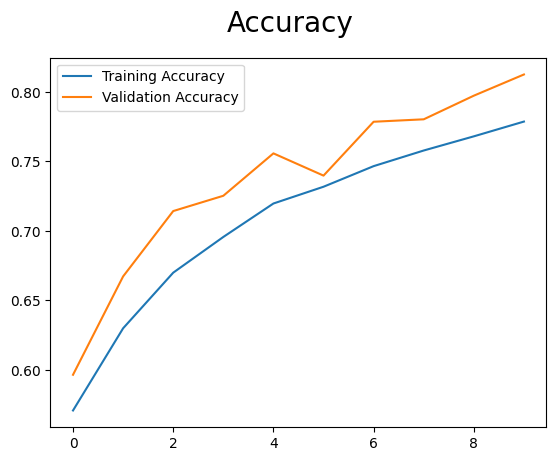

In [15]:
import matplotlib.pyplot as plt
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

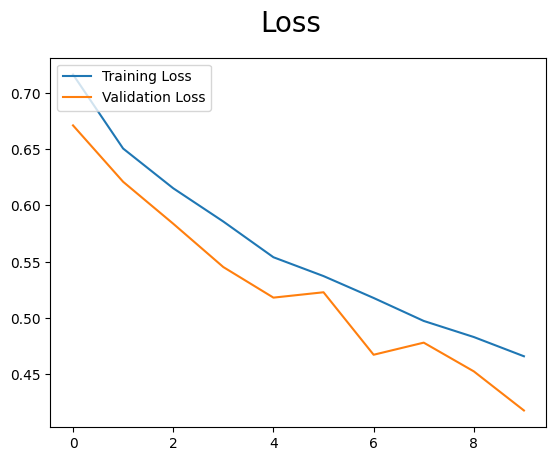

In [16]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()


In [17]:
from pathlib import Path

output_path = Path("/content/data/sorted_data/val")  # Adjust as needed

print("Cats images:", list((output_path / 'cats').glob('*.jpg')))

print("Dogs images:", list((output_path / 'dogs').glob('*.jpg')))


Cats images: []
Dogs images: []


Randomly Select and Predict Images

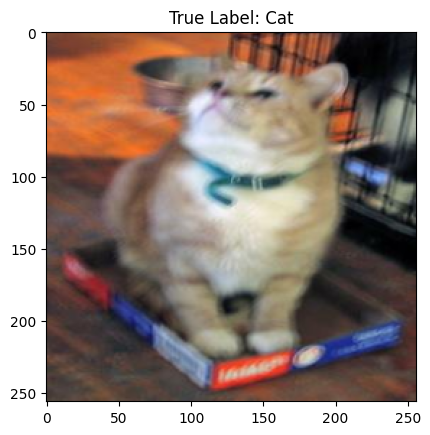

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Our Model Predicted as : Cat


In [42]:
import random
import matplotlib.pyplot as plt
import numpy as np
# Load one batch from the validation dataset
val_batch = next(iter(val_ds))

# Get random image and label
random_index = random.randint(0, val_batch[0].shape[0] - 1)
random_image, true_label = val_batch[0][random_index], val_batch[1][random_index]

# Display the image
plt.imshow(random_image.numpy())
plt.title("True Label: " + ("Dog" if true_label else "Cat"))
plt.show()

# Predict the class
prediction = model.predict(np.expand_dims(random_image, 0))
print("Our Model Predicted as : Dog" if prediction > 0.5 else "Our Model Predicted as : Cat")


Save and Load the Model

In [31]:
model.save("cats_vs_dogs_model.keras")

# Load the model
from tensorflow.keras.models import load_model
new_model = load_model("cats_vs_dogs_model.keras")